Some basic analysis of the tweets over the given time period 
*11/22/2016  10:57:33 AM and 11/23/2016  6:40:30 PM*

In [1]:
# This R environment comes with all of CRAN preinstalled, as well as many other helpful packages
# The environment is defined by the kaggle/rstats docker image: https://github.com/kaggle/docker-rstats
# For example, here's several helpful packages to load in 

library(ggplot2) # Data visualization
library(readr) # CSV file I/O, e.g. the read_csv function

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

system("ls ../input")
Kaggle_demonetization_tweets <- read_csv("../input/demonetization-tweets.csv", 
    col_types = cols(id = col_character(), 
        replyToSID = col_character()))
# Any results you write to the current directory are saved as output.

Warning message:
“Missing column names filled in: 'X1' [1]”


Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘scales’

The following object is masked from ‘package:readr’:

    col_factor


Attaching package: ‘dplyr’

The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



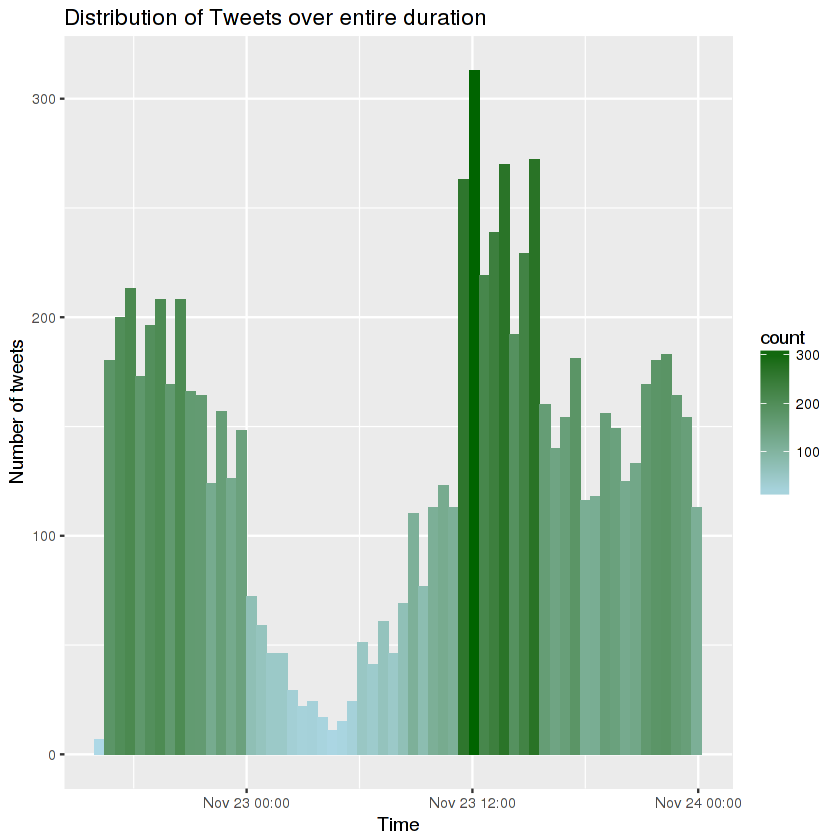

In [2]:
library(plotly)			# ggplot and dependencies
library(lubridate)		# Timezone conversion
library(scales)			# Regularly spaced dates (date_breaks)
library(dplyr)			
library(stringr)

# Strip the timestamp into components to see the distribution of tweets over time
Kaggle_demonetization_tweets$created <- ymd_hms(Kaggle_demonetization_tweets$created)
# Change to India Timezone from UTC as the user activity seems to be peaking during odd hours otherwise
Kaggle_demonetization_tweets$created <- with_tz(Kaggle_demonetization_tweets$created, "Asia/Colombo")

# Frequency plot
ggplot(data = Kaggle_demonetization_tweets, aes(x = Kaggle_demonetization_tweets$created)) +
    geom_histogram(aes(fill = ..count..), bins=60) +
    xlab("Time") + ylab("Number of tweets") + labs(title = "Distribution of Tweets over entire duration") +
    scale_fill_gradient(low = "lightblue", high = "darkgreen")

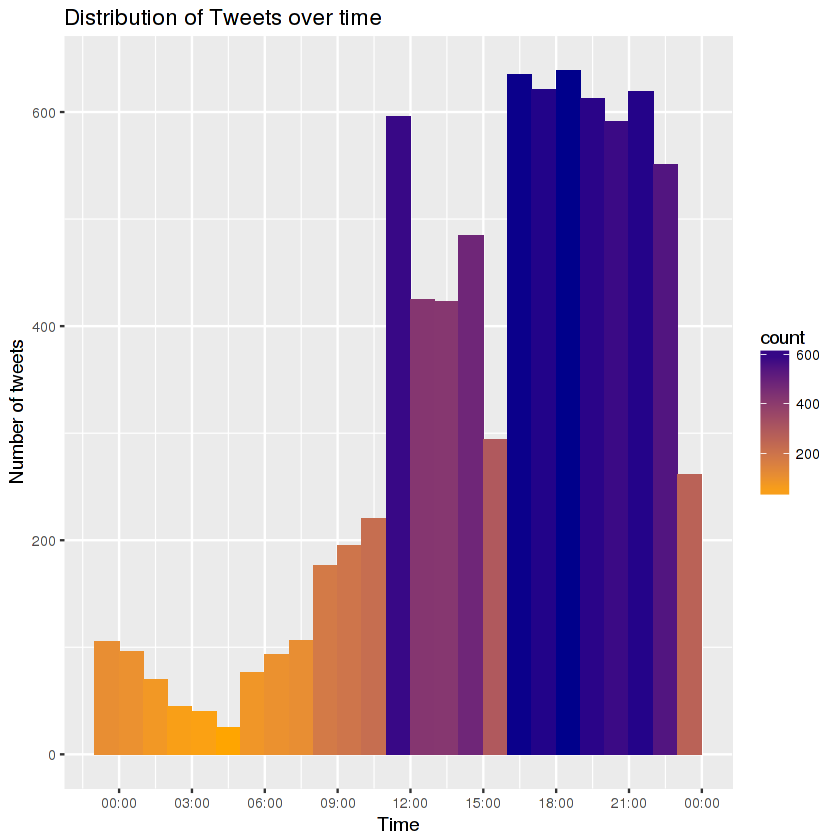

In [3]:
# Distribution of tweets by hour of the day (24hr period). I.e. Ignoring number of days, say at 4pm, 5pm, 6pm, etc. how many tweets were there?
Kaggle_demonetization_tweets$timeonly <- as.numeric(Kaggle_demonetization_tweets$created - trunc(Kaggle_demonetization_tweets$created, "days"))
class(Kaggle_demonetization_tweets$timeonly) <- "POSIXct"
Kaggle_demonetization_tweets$timeonly <- with_tz(Kaggle_demonetization_tweets$timeonly, "Asia/Colombo")

ggplot(data = Kaggle_demonetization_tweets, aes(x = timeonly)) +
    geom_histogram(aes(fill = ..count..), bins = 25) +
    xlab("Time") + ylab("Number of tweets") + labs(title = "Distribution of Tweets over time") + 
    scale_x_datetime(breaks = date_breaks("3 hours"), labels = date_format("%H:00")) + 
	scale_fill_gradient(low = "orange", high = "darkblue")

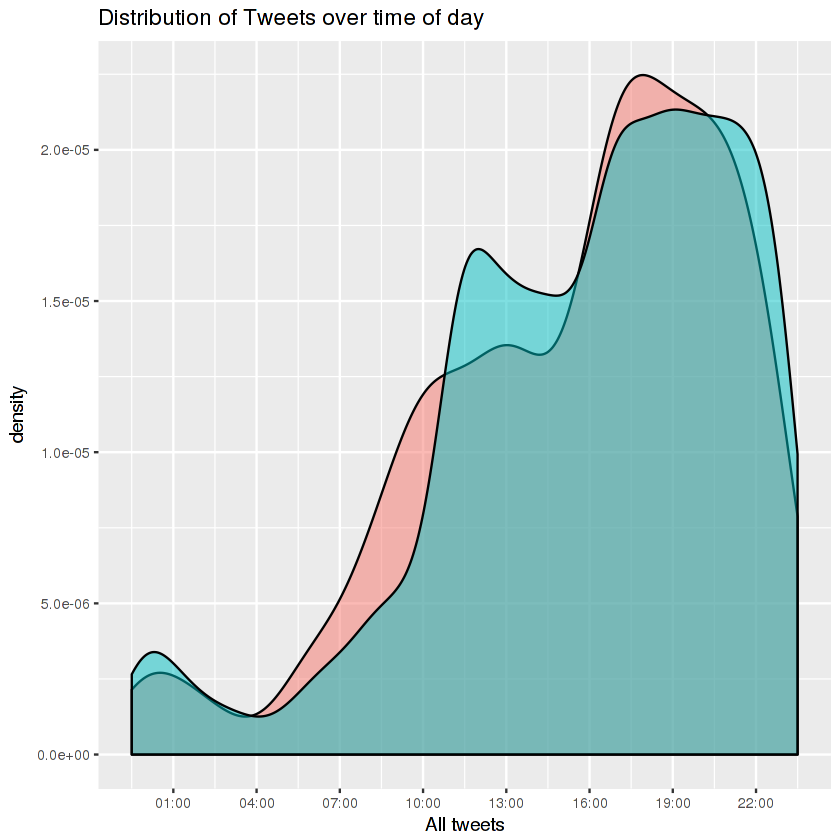

In [4]:
# Distribution of Tweets over time of day with "isRetweet" overlay
ggplot(Kaggle_demonetization_tweets, aes(timeonly)) + 
    geom_density(aes(fill = isRetweet), alpha = .5) +
    scale_fill_discrete(guide = 'none') +
	scale_x_datetime(breaks = date_breaks("3 hours"), labels = date_format("%H:00")) +    
	xlab('All tweets') + labs(title = "Distribution of Tweets over time of day")

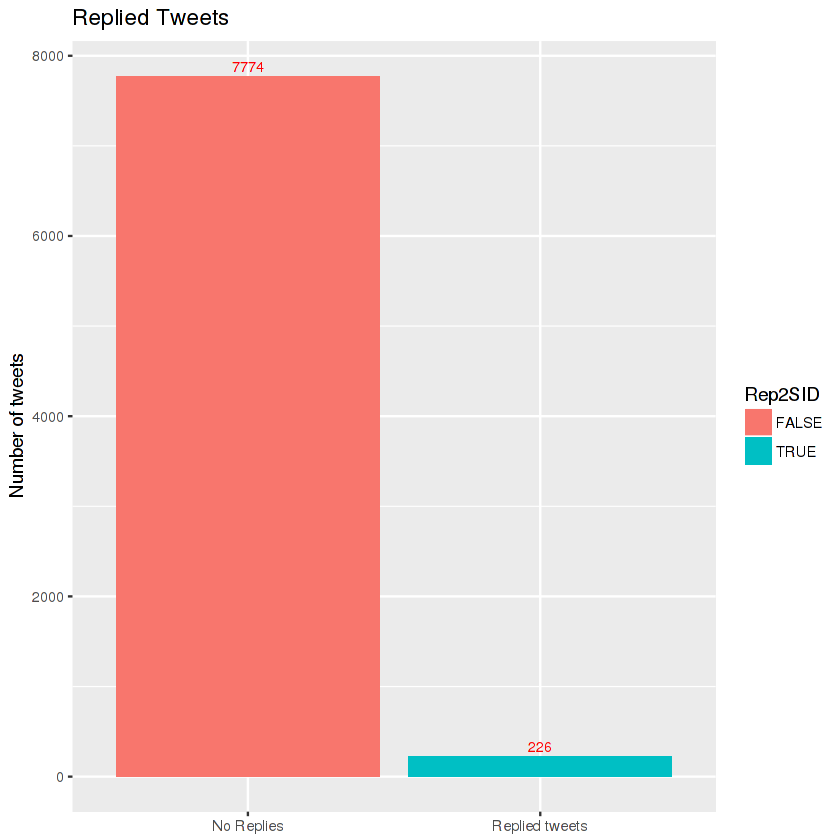

In [5]:
# Understanding the reply habits of Twitterati's
Rep2SID <- factor(!is.na(Kaggle_demonetization_tweets$replyToSID))
dfRep2SID <- as.data.frame(table(Rep2SID))

Reply.Source <- ggplot(Kaggle_demonetization_tweets, aes(factor(!is.na(replyToSID)))) +
    geom_bar(fill = "midnightblue") +
	geom_text(data = dfRep2SID, aes(x=Rep2SID, y=Freq, label=Freq), vjust= -0.4, colour = "red", size = 3) +
    theme(axis.title.x = element_blank()) +
    ylab("Number of tweets") + 
    ggtitle("Replied Tweets") +
    scale_x_discrete(labels=c("No Replies", "Replied tweets"))

Reply.Source + geom_bar(aes(fill = Rep2SID))

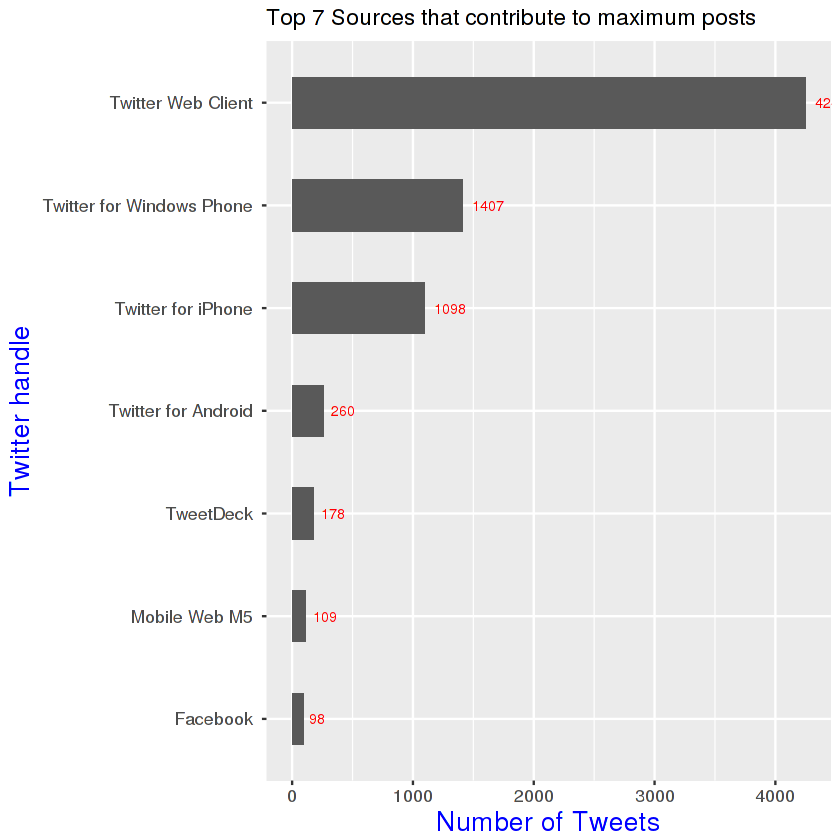

In [6]:
# Twitter handles with maximum posts (TOP 10)
# Cleanup all URLs in statusSource column. In other words, extract all characters between > and < 
Kaggle_demonetization_tweets$statusSource <- gsub("http[^[:blank:]]+", " ", Kaggle_demonetization_tweets$statusSource)
Kaggle_demonetization_tweets$statusSource <- gsub("[[:punct:]]", " ", Kaggle_demonetization_tweets$statusSource)
Kaggle_demonetization_tweets$statusSource <- gsub(" a ", " ", Kaggle_demonetization_tweets$statusSource)
Kaggle_demonetization_tweets$statusSource <- gsub("[ \t]{2,}", " ", Kaggle_demonetization_tweets$statusSource)
Kaggle_demonetization_tweets$statusSource <- gsub("^\\s+|\\s+$", " ", Kaggle_demonetization_tweets$statusSource)
Kaggle_demonetization_tweets$statusSource <- gsub(" a href rel nofollow ", " ", Kaggle_demonetization_tweets$statusSource)
Kaggle_demonetization_tweets$statusSource <- gsub(" href rel nofollow ", " ", Kaggle_demonetization_tweets$statusSource)

tweetsBySource <- Kaggle_demonetization_tweets %>%
    group_by(statusSource) %>%
    summarize(freqSrc=n()) %>%
    arrange(desc(freqSrc))

tweetsBySource.Top <- tweetsBySource[order(-tweetsBySource$freqSrc),]
tweetsBySource.Top7 <- tweetsBySource.Top[1:7,]

ggplot(tweetsBySource.Top7, aes(sort(tweetsBySource.Top7$statusSource,decreasing = T),tweetsBySource.Top7$freqSrc)) + 
    geom_bar(stat = "identity", width=0.5) + coord_flip() +
    geom_text(aes(label=tweetsBySource.Top7$freqSrc), hjust = -0.3, size =3, color = "red") +
    ylab("Number of Tweets") + xlab("Twitter handle") + labs(title = "Top 7 Sources that contribute to maximum posts") +
    theme(axis.text=element_text(size=10), 
          axis.title=element_text(size=16, colour = "blue"))

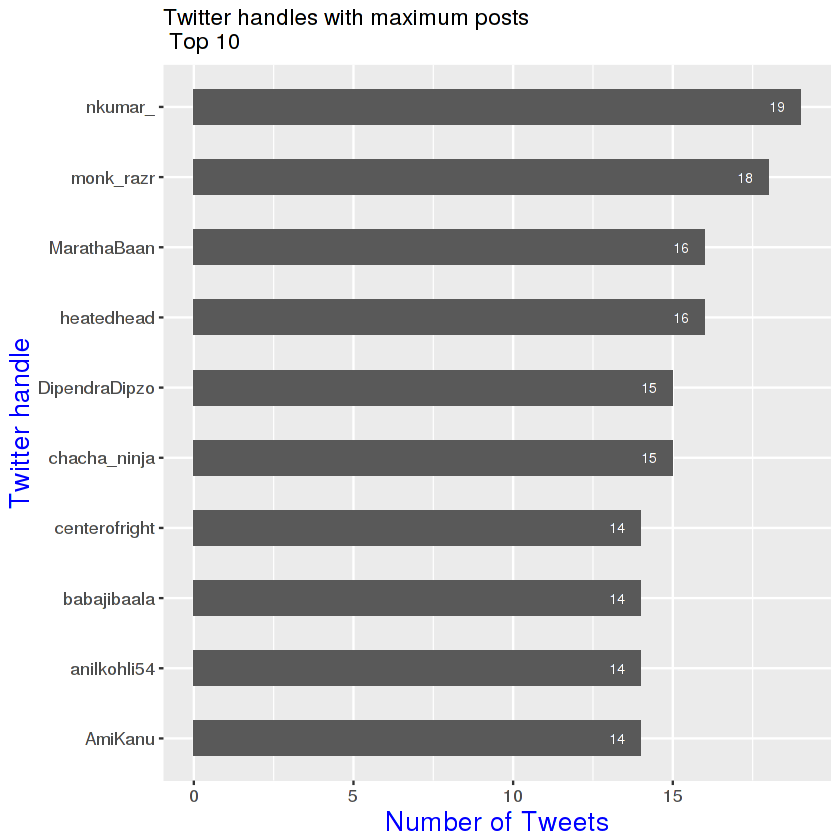

In [7]:
# Finding the Twitter handles that were the most active or those who had the maximum number of posts
tweetsPerUser <- Kaggle_demonetization_tweets %>%
    group_by(screenName) %>%
    summarize(freq=n()) %>%
    arrange(desc(freq))

tweetsPerUser.Top <- tweetsPerUser[order(-tweetsPerUser$freq),]
tweetsPerUser.Top10 <- tweetsPerUser.Top[1:10,]

ggplot(tweetsPerUser.Top10, aes(sort(tweetsPerUser.Top10$screenName,decreasing = T),tweetsPerUser.Top10$freq)) + 
    geom_bar(stat = "identity", width=0.5) + coord_flip() +
    geom_text(aes(label=tweetsPerUser.Top10$freq), hjust = 2, size =3, color = "white") +
    ylab("Number of Tweets") + xlab("Twitter handle") + labs(title = "Twitter handles with maximum posts\n Top 10") +
    theme(axis.text=element_text(size=10), 
          axis.title=element_text(size=16, colour = "blue"))


In [8]:
# Finding the number of hashtags 
Tot.hashcount <- sum(str_count(Kaggle_demonetization_tweets$text, "#"))  
print(paste0("Total number of hastags in text column: ", Tot.hashcount))


[1] "Total number of hastags in text column: 11318"
